In [18]:
import pandas as pd
import matplotlib.pyplot as plt

import csv
import sklearn
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer

from wordcloud import WordCloud

In [5]:
case = pd.read_csv('../legal_text_classification.csv')
case = case.dropna(subset=['case_text'])
case

,case_id,case_outcome,case_title,case_text
0,Case1,cited,Alpine Hardwood (Aust) Pty Ltd v Hardys Pty Lt...,Ordinarily that discretion will be exercised s...
1,Case2,cited,Black v Lipovac [1998] FCA 699 ; (1998) 217 AL...,The general principles governing the exercise ...
2,Case3,cited,Colgate Palmolive Co v Cussons Pty Ltd (1993) ...,Ordinarily that discretion will be exercised s...
3,Case4,cited,Dais Studio Pty Ltd v Bullett Creative Pty Ltd...,The general principles governing the exercise ...
4,Case5,cited,Dr Martens Australia Pty Ltd v Figgins Holding...,The preceding general principles inform the ex...
...,...,...,...,...
24980,Case25203,cited,Reches Pty Ltd v Tadiran Pty Ltd (1998) 85 FCR...,That is not confined to persons who control th...
24981,Case25204,cited,Sir Lindsay Parkinson &amp; Co Ltd v Triplan L...,Once the threshold prescribed by s 1335 is sat...
24982,Case25205,cited,Spiel v Commodity Brokers Australia Pty Ltd (I...,Once the threshold prescribed by s 1335 is sat...
24983,Case25206,distinguished,"Tullock Ltd v Walker (Unreported, Supreme Cour...",Given the extent to which Deumer stands to gai...


In [6]:
import re
import pandas as pd
import nltk
from gensim.parsing.preprocessing import preprocess_string

# clean, tokenize, and stem the text data
def preprocess_text(text):
    # remove email addresses
    text = re.sub(r'\S*@\S*\s?', '', text)
    # remove any non-alphanumeric characters and convert to lowercase
    text = re.sub('[,\.!?]', '', text)
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r"\'", "", text)
    text = text.lower()
    
    # preprocess text using gensim's preprocessing functions
    processed_text = preprocess_string(text)
    processed_text_str = ' '.join(processed_text)
    
    return processed_text_str

# apply the function to the column of text data in the df
case['case_text_processed'] = case['case_text'].apply(preprocess_text)
case['case_text_processed'].head()

0    ordinarili discret exercis cost follow event a...
1    gener principl govern exercis discret award in...
2    ordinarili discret exercis cost follow event a...
3    gener principl govern exercis discret award in...
4    preced gener principl inform exercis discret d...
Name: case_text_processed, dtype: object

In [7]:
case.head()

,case_id,case_outcome,case_title,case_text,case_text_processed
0,Case1,cited,Alpine Hardwood (Aust) Pty Ltd v Hardys Pty Lt...,Ordinarily that discretion will be exercised s...,ordinarili discret exercis cost follow event a...
1,Case2,cited,Black v Lipovac [1998] FCA 699 ; (1998) 217 AL...,The general principles governing the exercise ...,gener principl govern exercis discret award in...
2,Case3,cited,Colgate Palmolive Co v Cussons Pty Ltd (1993) ...,Ordinarily that discretion will be exercised s...,ordinarili discret exercis cost follow event a...
3,Case4,cited,Dais Studio Pty Ltd v Bullett Creative Pty Ltd...,The general principles governing the exercise ...,gener principl govern exercis discret award in...
4,Case5,cited,Dr Martens Australia Pty Ltd v Figgins Holding...,The preceding general principles inform the ex...,preced gener principl inform exercis discret d...


In [8]:
vec = TfidfVectorizer()
x = case['case_text_processed']
x = vec.fit_transform(x)

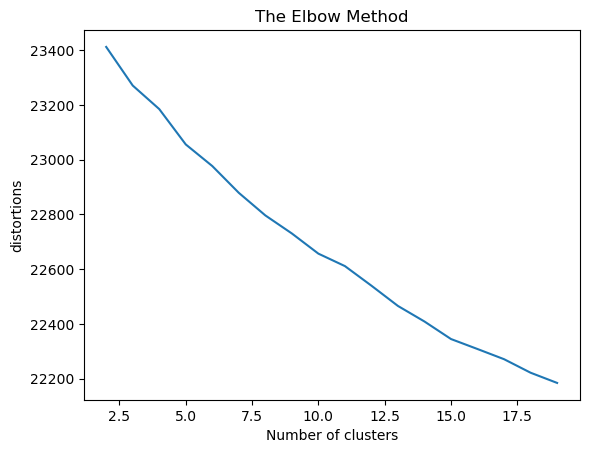

In [9]:
#Elbow

distortions = []
# K = range(1,11)
for i in range(2,20):
    kmeans = KMeans(n_clusters=i,init='random',max_iter=300,n_init=10,random_state=0)
    kmeans.fit(x)
    distortions.append(kmeans.inertia_)
    
plt.plot(range(2,20),distortions)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('distortions')
plt.show()

In [10]:
km = KMeans(
    n_clusters=3, init='random',
    n_init=10, max_iter=300, 
    tol=1e-04, random_state=0
)
y_km = km.fit_predict(x)
case_df = pd.DataFrame({'case_text' :case['case_text_processed'], 'topic_cluster' :y_km })

In [11]:
km.inertia_

23271.20341607228

In [12]:
case_df

,case_text,topic_cluster
0,ordinarili discret exercis cost follow event a...,2
1,gener principl govern exercis discret award in...,2
2,ordinarili discret exercis cost follow event a...,2
3,gener principl govern exercis discret award in...,2
4,preced gener principl inform exercis discret d...,0
...,...,...
24980,confin person control compani extend benefit p...,0
24981,threshold prescrib satisfi discret order secur...,0
24982,threshold prescrib satisfi discret order secur...,0
24983,given extent deumer stand gain proceed success...,0


In [13]:
case_df_0 = case_df[case_df['topic_cluster'] == 0]
case_df_1 = case_df[case_df['topic_cluster'] == 1]
case_df_2 = case_df[case_df['topic_cluster'] == 2]

In [14]:
from sklearn.feature_extraction.text import CountVectorizer

In [15]:
def get_top_n_words(corpus, n=10):
    vec = TfidfVectorizer()
    x = vec.fit_transform(corpus)
    sum_words = x.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

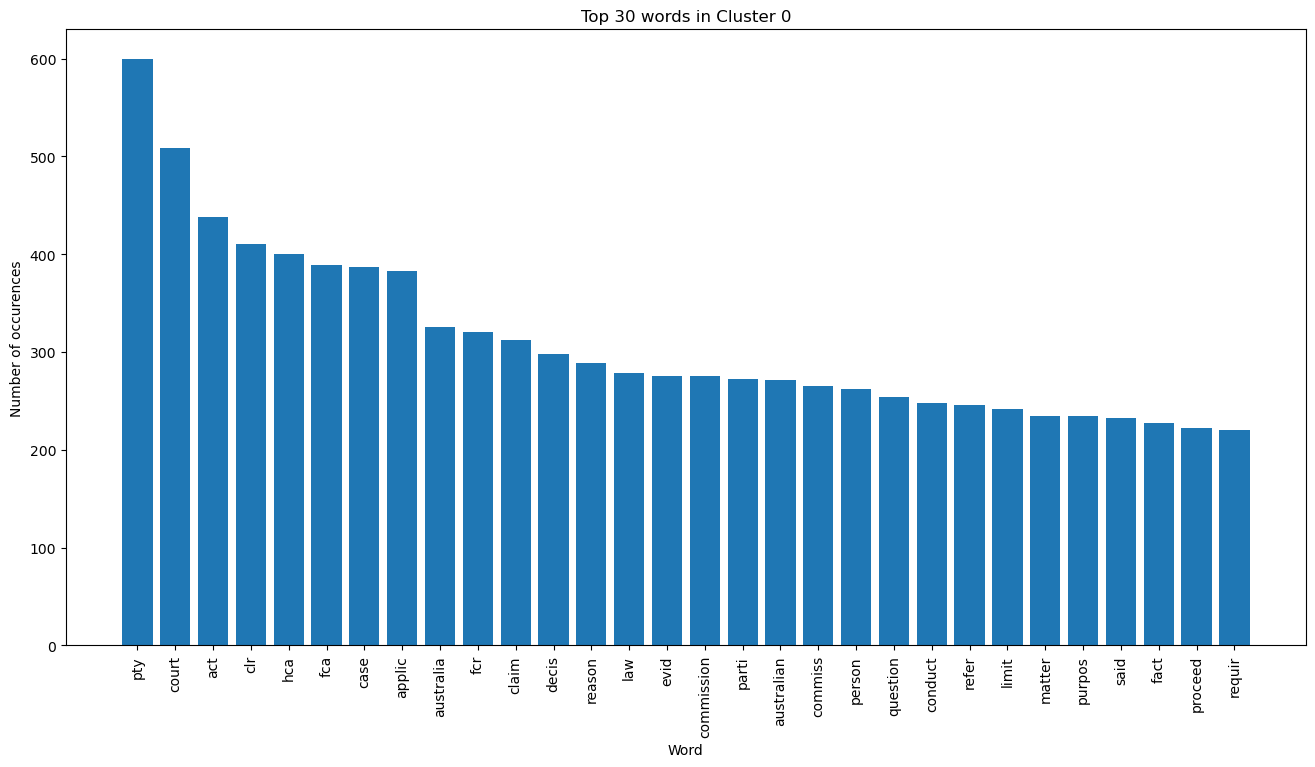

In [16]:
words = []
word_values = []
for i,j in get_top_n_words(case_df_0['case_text'],30):
  words.append(i)
  word_values.append(j)
    
fig, ax = plt.subplots(figsize=(16,8))
ax.bar(range(len(words)), word_values)
ax.set_xticks(range(len(words)))
ax.set_xticklabels(words, rotation='vertical')
ax.set_title('Top 30 words in Cluster 0')
ax.set_xlabel('Word')
ax.set_ylabel('Number of occurences')
plt.show()

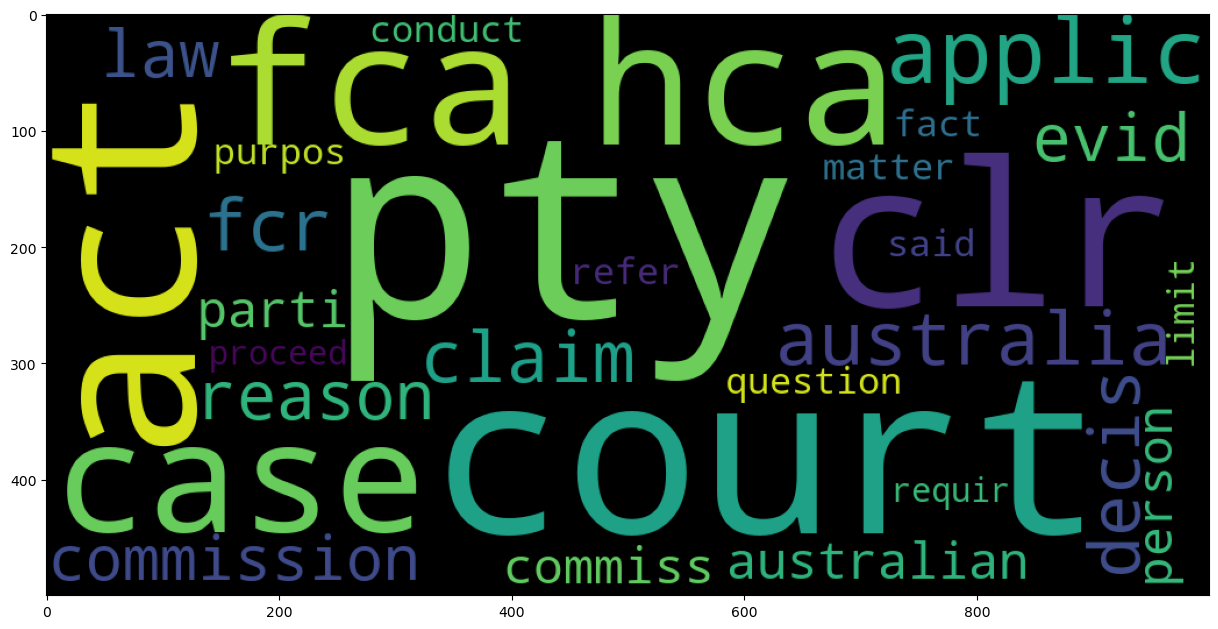

In [19]:
res = dict(zip(words, word_values))

wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(res)

plt.figure(figsize=(15,8))
plt.imshow(wordcloud)

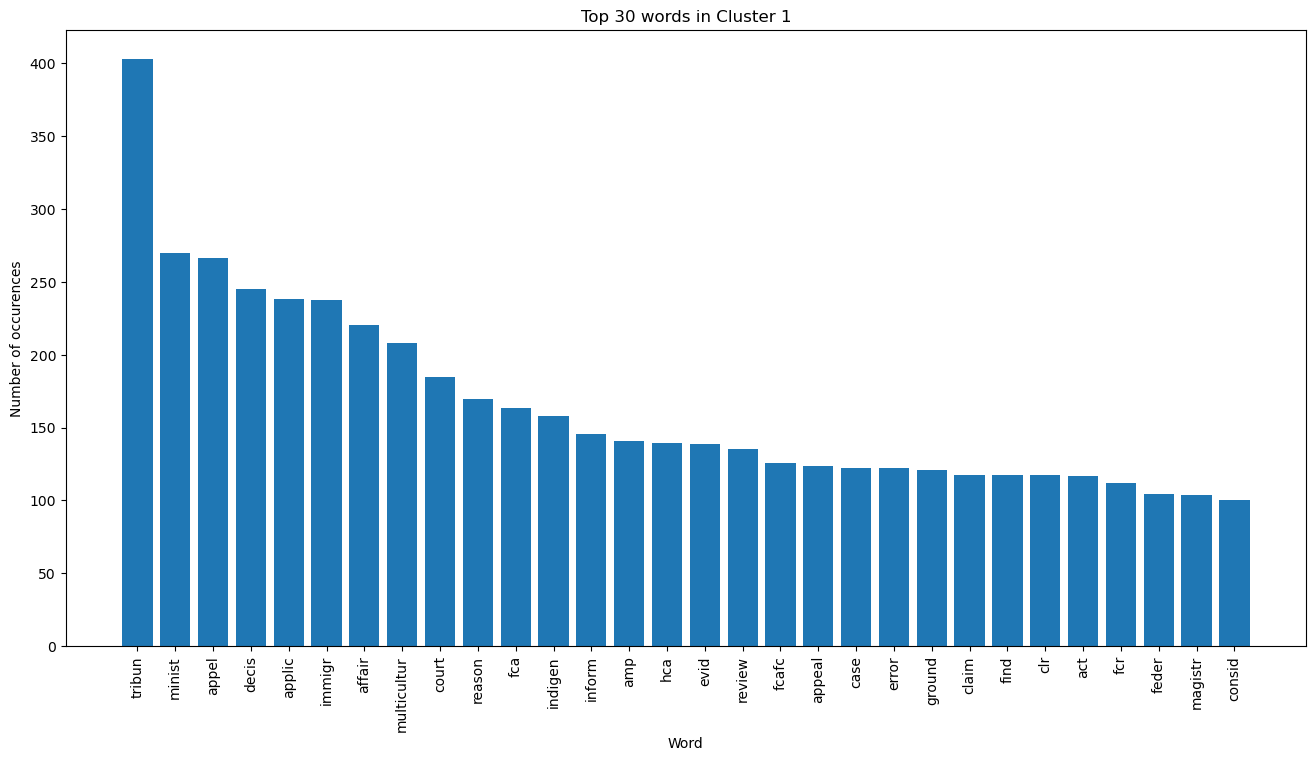

In [20]:
words = []
word_values = []
for i,j in get_top_n_words(case_df_1['case_text'],30):
  words.append(i)
  word_values.append(j)
    
fig, ax = plt.subplots(figsize=(16,8))
ax.bar(range(len(words)), word_values);
ax.set_xticks(range(len(words)));
ax.set_xticklabels(words, rotation='vertical');
ax.set_title('Top 30 words in Cluster 1');
ax.set_xlabel('Word');
ax.set_ylabel('Number of occurences');
plt.show()

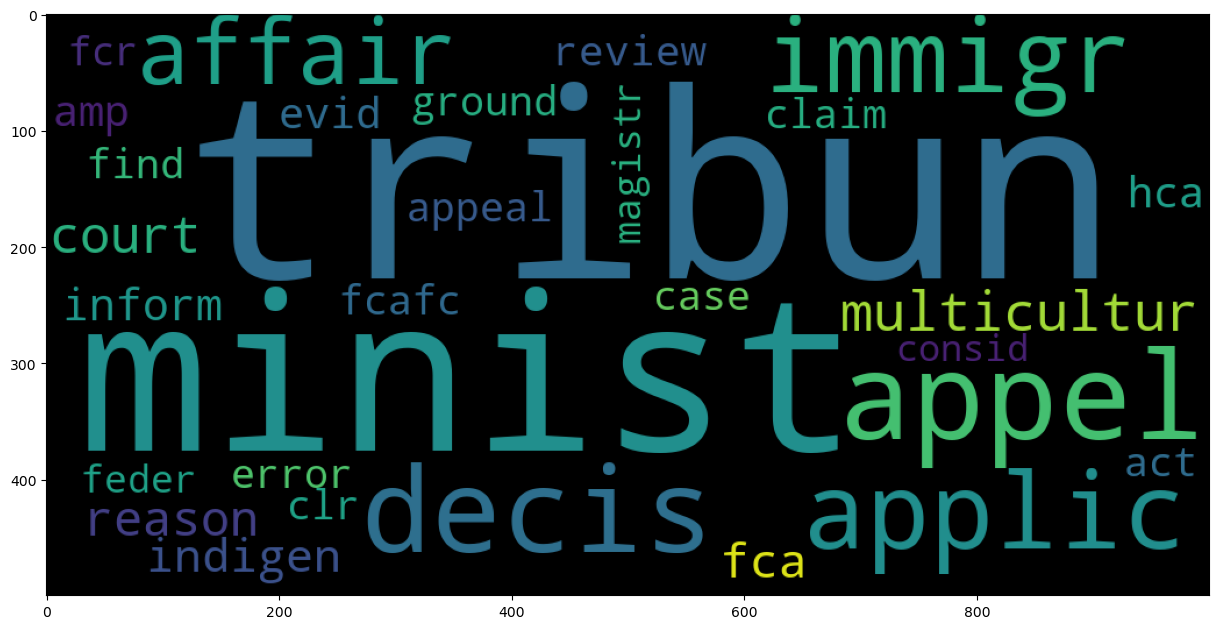

In [21]:
res = dict(zip(words, word_values))

wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(res)

plt.figure(figsize=(15,8))
plt.imshow(wordcloud)

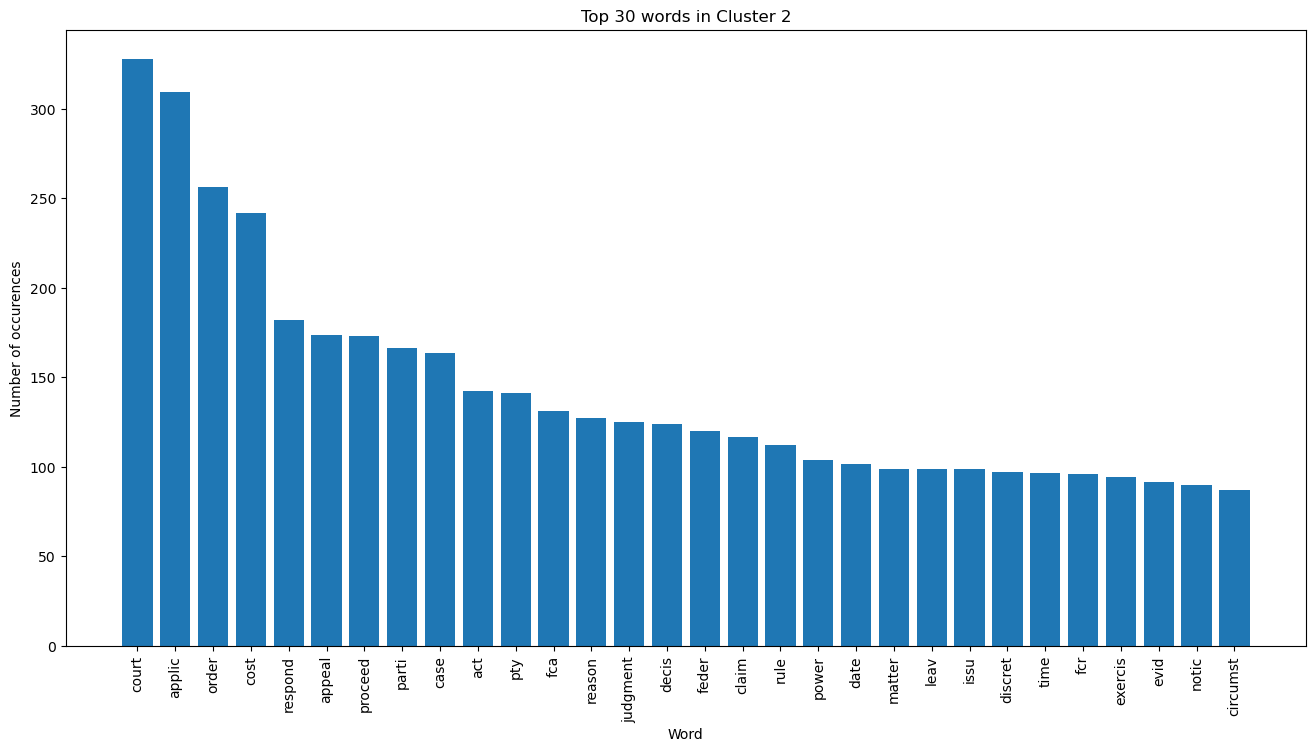

In [22]:
words = []
word_values = []
for i,j in get_top_n_words(case_df_2['case_text'],30):
  words.append(i)
  word_values.append(j)
    
fig, ax = plt.subplots(figsize=(16,8))
ax.bar(range(len(words)), word_values);
ax.set_xticks(range(len(words)));
ax.set_xticklabels(words, rotation='vertical');
ax.set_title('Top 30 words in Cluster 2');
ax.set_xlabel('Word');
ax.set_ylabel('Number of occurences');
plt.show()

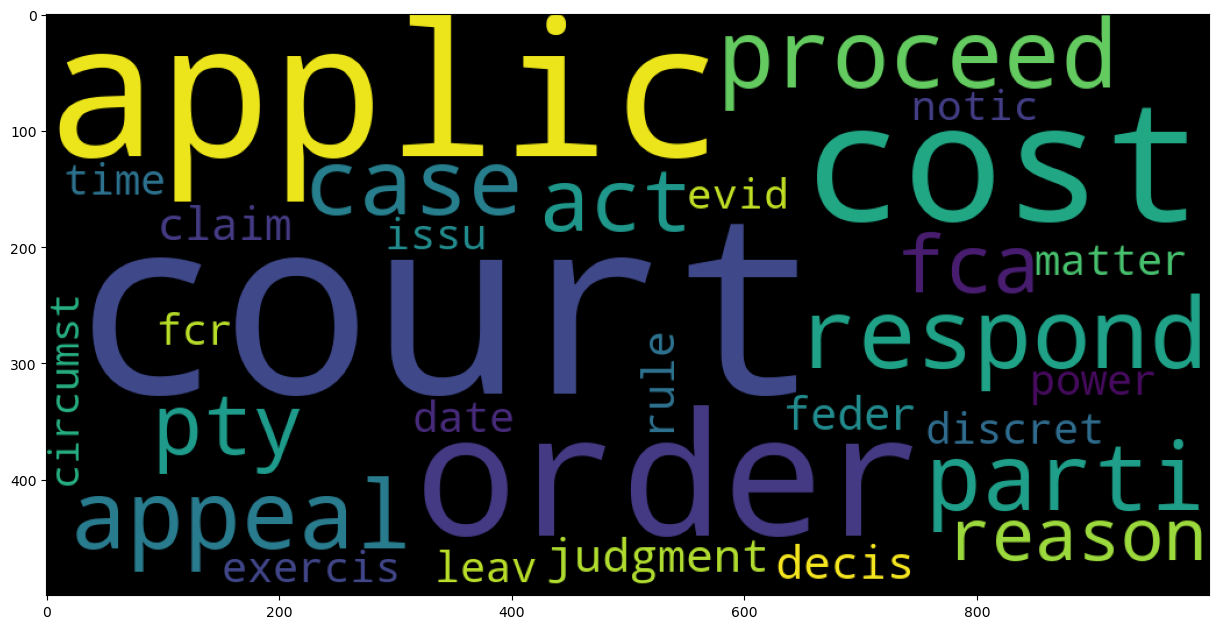

In [23]:
res = dict(zip(words, word_values))

wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(res)

plt.figure(figsize=(15,8))
plt.imshow(wordcloud)